### Test the trained network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 4
d = 3


/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-07-29_19:10"

epoch = 100

- Load gmm params

In [3]:
import numpy as np

In [4]:
filename='../../models/kddcup/{}/'.format(timestamp)+timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [5]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [6]:
K.eval(phi)

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [7]:
K.eval(mu)

array([[1.1386565, 1.1386565, 1.1386565],
       [1.1386565, 1.1386565, 1.1386565],
       [1.1386565, 1.1386565, 1.1386565],
       [1.1386565, 1.1386565, 1.1386565]], dtype=float32)

In [8]:
K.eval(sigma)

array([[[1.2112758 , 0.1714626 , 1.1308527 ],
        [0.1714626 , 0.02834561, 0.15191464],
        [1.1308527 , 0.15191464, 1.0722297 ]],

       [[1.2112758 , 0.1714626 , 1.1308527 ],
        [0.1714626 , 0.02834561, 0.15191464],
        [1.1308527 , 0.15191464, 1.0722297 ]],

       [[1.2112758 , 0.1714626 , 1.1308527 ],
        [0.1714626 , 0.02834561, 0.15191464],
        [1.1308527 , 0.15191464, 1.0722297 ]],

       [[1.2112758 , 0.1714626 , 1.1308527 ],
        [0.1714626 , 0.02834561, 0.15191464],
        [1.1308527 , 0.15191464, 1.0722297 ]]], dtype=float32)

- Plot loss history

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [11]:
def plotHistory(loss_array, save=False, savename='../../models/kddcup/{}/'.format(timestamp)+timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [12]:
filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

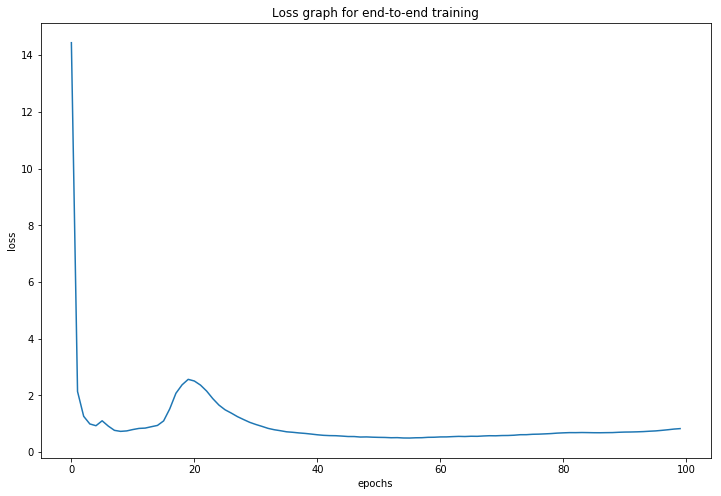

In [13]:
plotHistory(history, save=True)

- Network definition for testing

In [14]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 120)             0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 60)              7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 30)              1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1, 10)              310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [15]:
filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [16]:
import numpy as np

In [17]:
with np.load('../../datasets/kddcup/kdd99_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']

In [18]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [19]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [20]:
normal_data.shape

(198378, 120)

In [21]:
anomaly_data.shape

(48633, 120)

### Obtain sample energies

- Energies from normal class

In [22]:
energies_normal = eval_net.predict(normal_data, batch_size=1, verbose=1)  

198378/198378 [==============================] - 104s 522us/step


In [23]:
energies_normal

array([-3.8851197,  4.07738  , -3.8851197, ..., -3.8851197, -3.264968 ,
       -3.7553606], dtype=float32)

In [24]:
energies_normal.min()

-4.0298605

In [25]:
energies_normal.max()

13.815511

In [26]:
hist_bins = 500

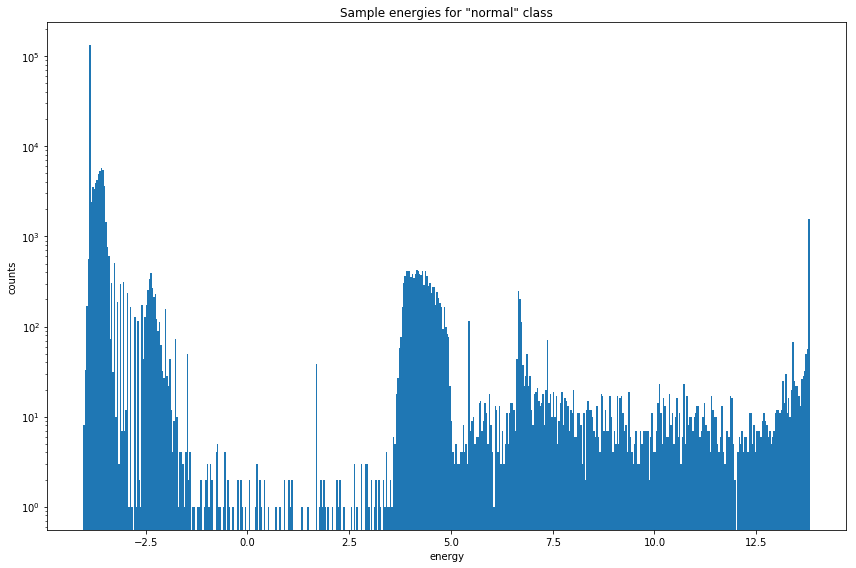

In [27]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [28]:
energies_anomaly = eval_net.predict(anomaly_data, batch_size=1, verbose=1)  

48633/48633 [==============================] - 26s 531us/step


In [29]:
energies_anomaly

array([13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
       13.815511], dtype=float32)

In [30]:
energies_anomaly.min()

12.418318

In [31]:
energies_anomaly.max()

13.815511

In [32]:
plt.hist?

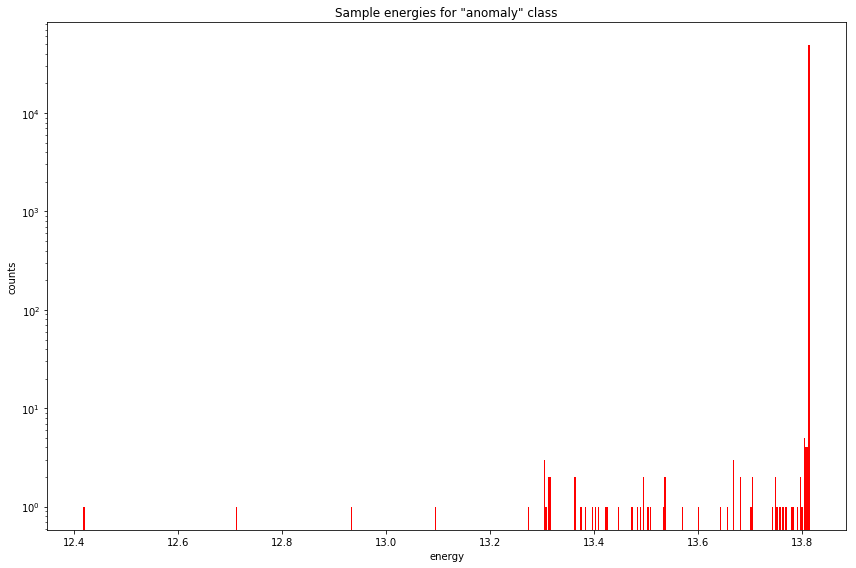

In [33]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

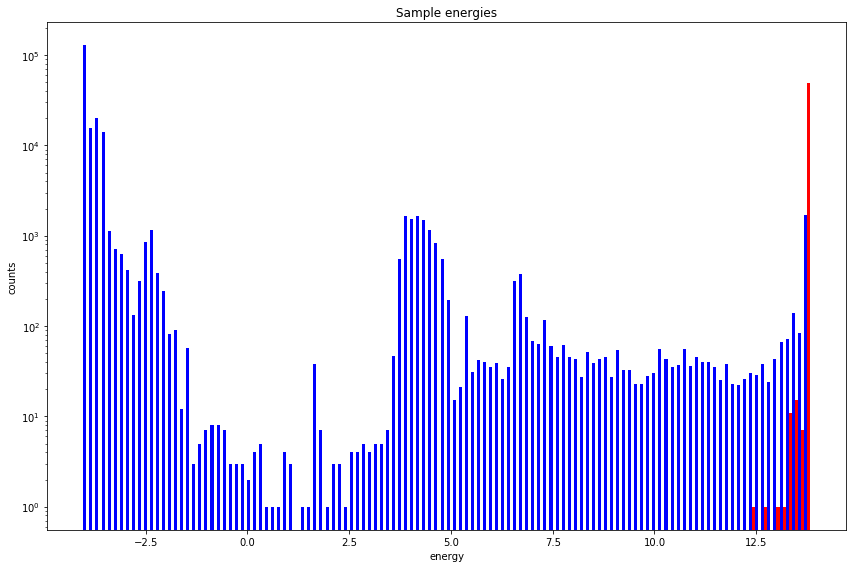

In [34]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [35]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [36]:
energies_all.shape

(247011,)

- Sort calculated energies descending

In [37]:
sorted_energies = np.sort(energies_all)[::-1]

In [38]:
sorted_energies

array([13.815511 , 13.815511 , 13.815511 , ..., -4.018523 , -4.02376  ,
       -4.0298605], dtype=float32)

- Top %20 percent is the first %20 part of it

In [39]:
threshold_index = int(np.floor(len(sorted_energies) * 0.2))

In [40]:
sorted_energies[:threshold_index]

array([13.815511, 13.815511, 13.815511, ..., 13.81551 , 13.81551 ,
       13.81551 ], dtype=float32)

In [41]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [42]:
threshold

13.81551

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [61]:
tp = len(energies_anomaly[energies_anomaly >= threshold])
fp = len(energies_normal[energies_normal > threshold])

tn = len(energies_normal[energies_normal <= threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])

In [62]:
precision = tp / (tp + fp)

In [63]:
precision

0.19690589750026316

In [64]:
recall = tp / (tp + fn)

In [65]:
recall

1.0

In [66]:
f1 = 2*tp / (2*tp + fp + fn)

In [67]:
f1

0.3290248597011694

# Naive approach to get anomaly threshold. 


In [69]:
anomaly_percentage_naive = anomaly_data.shape[0]/energies_all.shape[0]

threshold_index = int(np.floor(len(sorted_energies) * anomaly_percentage_naive))
threshold = sorted_energies[threshold_index]
    
tp = len(energies_anomaly[energies_anomaly >= threshold])
fp = len(energies_normal[energies_normal > threshold]) 

tn = len(energies_normal[energies_normal <= threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])
print(tp, fp, tn, fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2*tp / (2*tp + fp + fn)

print('precision: {}, recall: {}, f1_score: {}, anomaly_percentage_naive: {}, threshold: {}'
      .format(precision, recall, f1, anomaly_percentage_naive, threshold))

48470 0 198378 163
precision: 1.0, recall: 0.9966483663356157, f1_score: 0.9983213700915523, anomaly_percentage_naive: 0.19688596864107266, threshold: 13.815510749816895


# Naive approach to get anomaly threshold. 


In [70]:

precision_vals = []
anomaly_percentage_vals = []
recall_vals = []
f1_vals = []

for anomaly_percentage in range(0,10000, 1):
    print(anomaly_percentage)
    threshold_index = int(np.floor(len(sorted_energies) * anomaly_percentage/10000))
    threshold = sorted_energies[threshold_index]
    tp = len(energies_anomaly[energies_anomaly >= threshold]) 
    fp = len(energies_normal[energies_normal > threshold])

    tn = len(energies_normal[energies_normal <= threshold])
    fn = len(energies_anomaly[energies_anomaly < threshold])
    print(tp, fp, tn, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*tp / (2*tp + fp + fn)
    
    precision_vals.append(precision)
    anomaly_percentage_vals.append(anomaly_percentage)
    recall_vals.append(recall)
    f1_vals.append(f1)

0
48470 0 198378 163
1
48470 0 198378 163
2
48470 0 198378 163
3
48470 0 198378 163
4
48470 0 198378 163
5
48470 0 198378 163
6
48470 0 198378 163
7
48470 0 198378 163
8
48470 0 198378 163
9
48470 0 198378 163
10
48470 0 198378 163
11
48470 0 198378 163
12
48470 0 198378 163
13
48470 0 198378 163
14
48470 0 198378 163
15
48470 0 198378 163
16
48470 0 198378 163
17
48470 0 198378 163
18
48470 0 198378 163
19
48470 0 198378 163
20
48470 0 198378 163
21
48470 0 198378 163
22
48470 0 198378 163
23
48470 0 198378 163
24
48470 0 198378 163
25
48470 0 198378 163
26
48470 0 198378 163
27
48470 0 198378 163
28
48470 0 198378 163
29
48470 0 198378 163
30
48470 0 198378 163
31
48470 0 198378 163
32
48470 0 198378 163
33
48470 0 198378 163
34
48470 0 198378 163
35
48470 0 198378 163
36
48470 0 198378 163
37
48470 0 198378 163
38
48470 0 198378 163
39
48470 0 198378 163
40
48470 0 198378 163
41
48470 0 198378 163
42
48470 0 198378 163
43
48470 0 198378 163
44
48470 0 198378 163
45
48470 0 198378 16

48470 0 198378 163
377
48470 0 198378 163
378
48470 0 198378 163
379
48470 0 198378 163
380
48470 0 198378 163
381
48470 0 198378 163
382
48470 0 198378 163
383
48470 0 198378 163
384
48470 0 198378 163
385
48470 0 198378 163
386
48470 0 198378 163
387
48470 0 198378 163
388
48470 0 198378 163
389
48470 0 198378 163
390
48470 0 198378 163
391
48470 0 198378 163
392
48470 0 198378 163
393
48470 0 198378 163
394
48470 0 198378 163
395
48470 0 198378 163
396
48470 0 198378 163
397
48470 0 198378 163
398
48470 0 198378 163
399
48470 0 198378 163
400
48470 0 198378 163
401
48470 0 198378 163
402
48470 0 198378 163
403
48470 0 198378 163
404
48470 0 198378 163
405
48470 0 198378 163
406
48470 0 198378 163
407
48470 0 198378 163
408
48470 0 198378 163
409
48470 0 198378 163
410
48470 0 198378 163
411
48470 0 198378 163
412
48470 0 198378 163
413
48470 0 198378 163
414
48470 0 198378 163
415
48470 0 198378 163
416
48470 0 198378 163
417
48470 0 198378 163
418
48470 0 198378 163
419
48470 0 198

48470 0 198378 163
777
48470 0 198378 163
778
48470 0 198378 163
779
48470 0 198378 163
780
48470 0 198378 163
781
48470 0 198378 163
782
48470 0 198378 163
783
48470 0 198378 163
784
48470 0 198378 163
785
48470 0 198378 163
786
48470 0 198378 163
787
48470 0 198378 163
788
48470 0 198378 163
789
48470 0 198378 163
790
48470 0 198378 163
791
48470 0 198378 163
792
48470 0 198378 163
793
48470 0 198378 163
794
48470 0 198378 163
795
48470 0 198378 163
796
48470 0 198378 163
797
48470 0 198378 163
798
48470 0 198378 163
799
48470 0 198378 163
800
48470 0 198378 163
801
48470 0 198378 163
802
48470 0 198378 163
803
48470 0 198378 163
804
48470 0 198378 163
805
48470 0 198378 163
806
48470 0 198378 163
807
48470 0 198378 163
808
48470 0 198378 163
809
48470 0 198378 163
810
48470 0 198378 163
811
48470 0 198378 163
812
48470 0 198378 163
813
48470 0 198378 163
814
48470 0 198378 163
815
48470 0 198378 163
816
48470 0 198378 163
817
48470 0 198378 163
818
48470 0 198378 163
819
48470 0 198

48470 0 198378 163
1176
48470 0 198378 163
1177
48470 0 198378 163
1178
48470 0 198378 163
1179
48470 0 198378 163
1180
48470 0 198378 163
1181
48470 0 198378 163
1182
48470 0 198378 163
1183
48470 0 198378 163
1184
48470 0 198378 163
1185
48470 0 198378 163
1186
48470 0 198378 163
1187
48470 0 198378 163
1188
48470 0 198378 163
1189
48470 0 198378 163
1190
48470 0 198378 163
1191
48470 0 198378 163
1192
48470 0 198378 163
1193
48470 0 198378 163
1194
48470 0 198378 163
1195
48470 0 198378 163
1196
48470 0 198378 163
1197
48470 0 198378 163
1198
48470 0 198378 163
1199
48470 0 198378 163
1200
48470 0 198378 163
1201
48470 0 198378 163
1202
48470 0 198378 163
1203
48470 0 198378 163
1204
48470 0 198378 163
1205
48470 0 198378 163
1206
48470 0 198378 163
1207
48470 0 198378 163
1208
48470 0 198378 163
1209
48470 0 198378 163
1210
48470 0 198378 163
1211
48470 0 198378 163
1212
48470 0 198378 163
1213
48470 0 198378 163
1214
48470 0 198378 163
1215
48470 0 198378 163
1216
48470 0 198378 1

48470 0 198378 163
1576
48470 0 198378 163
1577
48470 0 198378 163
1578
48470 0 198378 163
1579
48470 0 198378 163
1580
48470 0 198378 163
1581
48470 0 198378 163
1582
48470 0 198378 163
1583
48470 0 198378 163
1584
48470 0 198378 163
1585
48470 0 198378 163
1586
48470 0 198378 163
1587
48470 0 198378 163
1588
48470 0 198378 163
1589
48470 0 198378 163
1590
48470 0 198378 163
1591
48470 0 198378 163
1592
48470 0 198378 163
1593
48470 0 198378 163
1594
48470 0 198378 163
1595
48470 0 198378 163
1596
48470 0 198378 163
1597
48470 0 198378 163
1598
48470 0 198378 163
1599
48470 0 198378 163
1600
48470 0 198378 163
1601
48470 0 198378 163
1602
48470 0 198378 163
1603
48470 0 198378 163
1604
48470 0 198378 163
1605
48470 0 198378 163
1606
48470 0 198378 163
1607
48470 0 198378 163
1608
48470 0 198378 163
1609
48470 0 198378 163
1610
48470 0 198378 163
1611
48470 0 198378 163
1612
48470 0 198378 163
1613
48470 0 198378 163
1614
48470 0 198378 163
1615
48470 0 198378 163
1616
48470 0 198378 1

48489 939 197439 144
2004
48493 990 197388 140
2005
48493 990 197388 140
2006
48493 990 197388 140
2007
48493 990 197388 140
2008
48493 990 197388 140
2009
48493 990 197388 140
2010
48493 990 197388 140
2011
48493 1174 197204 140
2012
48493 1174 197204 140
2013
48494 1229 197149 139
2014
48500 1247 197131 133
2015
48508 1264 197114 125
2016
48519 1281 197097 114
2017
48522 1301 197077 111
2018
48533 1313 197065 100
2019
48543 1320 197058 90
2020
48543 1335 197043 90
2021
48546 1374 197004 87
2022
48552 1393 196985 81
2023
48555 1415 196963 78
2024
48559 1436 196942 74
2025
48562 1457 196921 71
2026
48566 1478 196900 67
2027
48570 1499 196879 63
2028
48575 1518 196860 58
2029
48578 1540 196838 55
2030
48580 1563 196815 53
2031
48581 1586 196792 52
2032
48583 1606 196772 50
2033
48588 1629 196749 45
2034
48588 1654 196724 45
2035
48590 1676 196702 43
2036
48593 1698 196680 40
2037
48597 1719 196659 36
2038
48598 1741 196637 35
2039
48599 1766 196612 34
2040
48603 1787 196591 30
2041
4860

48633 10180 188198 0
2382
48633 10205 188173 0
2383
48633 10229 188149 0
2384
48633 10244 188134 0
2385
48633 10279 188099 0
2386
48633 10298 188080 0
2387
48633 10328 188050 0
2388
48633 10353 188025 0
2389
48633 10373 188005 0
2390
48633 10402 187976 0
2391
48633 10423 187955 0
2392
48633 10449 187929 0
2393
48633 10476 187902 0
2394
48633 10501 187877 0
2395
48633 10522 187856 0
2396
48633 10550 187828 0
2397
48633 10575 187803 0
2398
48633 10599 187779 0
2399
48633 10621 187757 0
2400
48633 10648 187730 0
2401
48633 10668 187710 0
2402
48633 10698 187680 0
2403
48633 10723 187655 0
2404
48633 10748 187630 0
2405
48633 10773 187605 0
2406
48633 10796 187582 0
2407
48633 10820 187558 0
2408
48633 10847 187531 0
2409
48633 10868 187510 0
2410
48633 10895 187483 0
2411
48633 10921 187457 0
2412
48633 10946 187432 0
2413
48633 10968 187410 0
2414
48633 10995 187383 0
2415
48633 11020 187358 0
2416
48633 11044 187334 0
2417
48633 11069 187309 0
2418
48633 11092 187286 0
2419
48633 11118 

48633 18912 179466 0
2739
48633 18912 179466 0
2740
48633 18912 179466 0
2741
48633 18912 179466 0
2742
48633 18912 179466 0
2743
48633 18912 179466 0
2744
48633 18912 179466 0
2745
48633 18912 179466 0
2746
48633 18912 179466 0
2747
48633 19214 179164 0
2748
48633 19214 179164 0
2749
48633 19214 179164 0
2750
48633 19214 179164 0
2751
48633 19214 179164 0
2752
48633 19214 179164 0
2753
48633 19214 179164 0
2754
48633 19214 179164 0
2755
48633 19418 178960 0
2756
48633 19423 178955 0
2757
48633 19423 178955 0
2758
48633 19423 178955 0
2759
48633 19423 178955 0
2760
48633 19423 178955 0
2761
48633 19423 178955 0
2762
48633 19423 178955 0
2763
48633 19423 178955 0
2764
48633 19423 178955 0
2765
48633 19423 178955 0
2766
48633 19423 178955 0
2767
48633 19423 178955 0
2768
48633 19423 178955 0
2769
48633 19423 178955 0
2770
48633 19423 178955 0
2771
48633 19423 178955 0
2772
48633 19423 178955 0
2773
48633 19423 178955 0
2774
48633 19423 178955 0
2775
48633 19912 178466 0
2776
48633 19937 

48633 27222 171156 0
3072
48633 27248 171130 0
3073
48633 27272 171106 0
3074
48633 27298 171080 0
3075
48633 27320 171058 0
3076
48633 27347 171031 0
3077
48633 27368 171010 0
3078
48633 27396 170982 0
3079
48633 27420 170958 0
3080
48633 27446 170932 0
3081
48633 27471 170907 0
3082
48633 27495 170883 0
3083
48633 27520 170858 0
3084
48633 27543 170835 0
3085
48633 27569 170809 0
3086
48633 27594 170784 0
3087
48633 27615 170763 0
3088
48633 27634 170744 0
3089
48633 27667 170711 0
3090
48633 27693 170685 0
3091
48633 27718 170660 0
3092
48633 27739 170639 0
3093
48633 27767 170611 0
3094
48633 27792 170586 0
3095
48633 27813 170565 0
3096
48633 27840 170538 0
3097
48633 27866 170512 0
3098
48633 27890 170488 0
3099
48633 27915 170463 0
3100
48633 27937 170441 0
3101
48633 27944 170434 0
3102
48633 27989 170389 0
3103
48633 28013 170365 0
3104
48633 28039 170339 0
3105
48633 28061 170317 0
3106
48633 28086 170292 0
3107
48633 28113 170265 0
3108
48633 28128 170250 0
3109
48633 28128 

48633 35153 163225 0
3393
48633 35176 163202 0
3394
48633 35201 163177 0
3395
48633 35225 163153 0
3396
48633 35248 163130 0
3397
48633 35270 163108 0
3398
48633 35301 163077 0
3399
48633 35324 163054 0
3400
48633 35350 163028 0
3401
48633 35373 163005 0
3402
48633 35400 162978 0
3403
48633 35421 162957 0
3404
48633 35446 162932 0
3405
48633 35473 162905 0
3406
48633 35495 162883 0
3407
48633 35522 162856 0
3408
48633 35548 162830 0
3409
48633 35571 162807 0
3410
48633 35595 162783 0
3411
48633 35622 162756 0
3412
48633 35647 162731 0
3413
48633 35671 162707 0
3414
48633 35696 162682 0
3415
48633 35720 162658 0
3416
48633 35744 162634 0
3417
48633 35768 162610 0
3418
48633 35789 162589 0
3419
48633 35819 162559 0
3420
48633 35843 162535 0
3421
48633 35869 162509 0
3422
48633 35894 162484 0
3423
48633 35916 162462 0
3424
48633 35942 162436 0
3425
48633 35968 162410 0
3426
48633 35992 162386 0
3427
48633 36013 162365 0
3428
48633 36041 162337 0
3429
48633 36067 162311 0
3430
48633 36091 

48633 43525 154853 0
3732
48633 43551 154827 0
3733
48633 43575 154803 0
3734
48633 43600 154778 0
3735
48633 43623 154755 0
3736
48633 43650 154728 0
3737
48633 43674 154704 0
3738
48633 43699 154679 0
3739
48633 43719 154659 0
3740
48633 43749 154629 0
3741
48633 43772 154606 0
3742
48633 43797 154581 0
3743
48633 43823 154555 0
3744
48633 43843 154535 0
3745
48633 43872 154506 0
3746
48633 43894 154484 0
3747
48633 43921 154457 0
3748
48633 43946 154432 0
3749
48633 43971 154407 0
3750
48633 43993 154385 0
3751
48633 44020 154358 0
3752
48633 44045 154333 0
3753
48633 44052 154326 0
3754
48633 44094 154284 0
3755
48633 44114 154264 0
3756
48633 44143 154235 0
3757
48633 44169 154209 0
3758
48633 44193 154185 0
3759
48633 44217 154161 0
3760
48633 44240 154138 0
3761
48633 44267 154111 0
3762
48633 44291 154087 0
3763
48633 44317 154061 0
3764
48633 44340 154038 0
3765
48633 44362 154016 0
3766
48633 44389 153989 0
3767
48633 44416 153962 0
3768
48633 44431 153947 0
3769
48633 44465 

48633 52792 145586 0
4109
48633 52792 145586 0
4110
48633 52792 145586 0
4111
48633 52792 145586 0
4112
48633 52937 145441 0
4113
48633 52962 145416 0
4114
48633 52984 145394 0
4115
48633 53012 145366 0
4116
48633 53035 145343 0
4117
48633 53061 145317 0
4118
48633 53086 145292 0
4119
48633 53110 145268 0
4120
48633 53135 145243 0
4121
48633 53158 145220 0
4122
48633 53179 145199 0
4123
48633 53209 145169 0
4124
48633 53232 145146 0
4125
48633 53257 145121 0
4126
48633 53283 145095 0
4127
48633 53308 145070 0
4128
48633 53333 145045 0
4129
48633 53357 145021 0
4130
48633 53382 144996 0
4131
48633 53407 144971 0
4132
48633 53429 144949 0
4133
48633 53455 144923 0
4134
48633 53481 144897 0
4135
48633 53505 144873 0
4136
48633 53520 144858 0
4137
48633 53520 144858 0
4138
48633 53579 144799 0
4139
48633 53604 144774 0
4140
48633 53629 144749 0
4141
48633 53635 144743 0
4142
48633 53635 144743 0
4143
48633 53702 144676 0
4144
48633 53727 144651 0
4145
48633 53751 144627 0
4146
48633 53777 

48633 60644 137734 0
4425
48633 60668 137710 0
4426
48633 60694 137684 0
4427
48633 60717 137661 0
4428
48633 60740 137638 0
4429
48633 60764 137614 0
4430
48633 60788 137590 0
4431
48633 60817 137561 0
4432
48633 60840 137538 0
4433
48633 60866 137512 0
4434
48633 60880 137498 0
4435
48633 60916 137462 0
4436
48633 60938 137440 0
4437
48633 60962 137416 0
4438
48633 60990 137388 0
4439
48633 61015 137363 0
4440
48633 61036 137342 0
4441
48633 61048 137330 0
4442
48633 61089 137289 0
4443
48633 61113 137265 0
4444
48633 61135 137243 0
4445
48633 61163 137215 0
4446
48633 61180 137198 0
4447
48633 61212 137166 0
4448
48633 61237 137141 0
4449
48633 61262 137116 0
4450
48633 61274 137104 0
4451
48633 61310 137068 0
4452
48633 61334 137044 0
4453
48633 61357 137021 0
4454
48633 61365 137013 0
4455
48633 61365 137013 0
4456
48633 61365 137013 0
4457
48633 61365 137013 0
4458
48633 61365 137013 0
4459
48633 61365 137013 0
4460
48633 61365 137013 0
4461
48633 61365 137013 0
4462
48633 61582 

48633 68157 130221 0
4743
48633 68157 130221 0
4744
48633 68157 130221 0
4745
48633 68157 130221 0
4746
48633 68157 130221 0
4747
48633 68157 130221 0
4748
48633 68157 130221 0
4749
48633 68157 130221 0
4750
48633 68157 130221 0
4751
48633 68157 130221 0
4752
48633 68157 130221 0
4753
48633 68157 130221 0
4754
48633 68157 130221 0
4755
48633 68157 130221 0
4756
48633 68157 130221 0
4757
48633 68157 130221 0
4758
48633 68157 130221 0
4759
48633 68157 130221 0
4760
48633 68157 130221 0
4761
48633 68157 130221 0
4762
48633 68157 130221 0
4763
48633 68157 130221 0
4764
48633 68157 130221 0
4765
48633 68157 130221 0
4766
48633 68157 130221 0
4767
48633 68157 130221 0
4768
48633 68157 130221 0
4769
48633 68157 130221 0
4770
48633 68157 130221 0
4771
48633 68157 130221 0
4772
48633 68157 130221 0
4773
48633 68157 130221 0
4774
48633 68157 130221 0
4775
48633 68157 130221 0
4776
48633 68157 130221 0
4777
48633 68157 130221 0
4778
48633 68157 130221 0
4779
48633 68157 130221 0
4780
48633 68157 

48633 71361 127017 0
5089
48633 71361 127017 0
5090
48633 71361 127017 0
5091
48633 71361 127017 0
5092
48633 71361 127017 0
5093
48633 71361 127017 0
5094
48633 71361 127017 0
5095
48633 71361 127017 0
5096
48633 71361 127017 0
5097
48633 71361 127017 0
5098
48633 71361 127017 0
5099
48633 71361 127017 0
5100
48633 71361 127017 0
5101
48633 71361 127017 0
5102
48633 71361 127017 0
5103
48633 71361 127017 0
5104
48633 71361 127017 0
5105
48633 71361 127017 0
5106
48633 71361 127017 0
5107
48633 71361 127017 0
5108
48633 71361 127017 0
5109
48633 71361 127017 0
5110
48633 71361 127017 0
5111
48633 71361 127017 0
5112
48633 71361 127017 0
5113
48633 71361 127017 0
5114
48633 71361 127017 0
5115
48633 71361 127017 0
5116
48633 71361 127017 0
5117
48633 71361 127017 0
5118
48633 71361 127017 0
5119
48633 71361 127017 0
5120
48633 71361 127017 0
5121
48633 71361 127017 0
5122
48633 71361 127017 0
5123
48633 71361 127017 0
5124
48633 71361 127017 0
5125
48633 71361 127017 0
5126
48633 71361 

48633 71361 127017 0
5457
48633 71361 127017 0
5458
48633 71361 127017 0
5459
48633 71361 127017 0
5460
48633 71361 127017 0
5461
48633 71361 127017 0
5462
48633 71361 127017 0
5463
48633 71361 127017 0
5464
48633 71361 127017 0
5465
48633 71361 127017 0
5466
48633 71361 127017 0
5467
48633 71361 127017 0
5468
48633 71361 127017 0
5469
48633 71361 127017 0
5470
48633 71361 127017 0
5471
48633 71361 127017 0
5472
48633 71361 127017 0
5473
48633 71361 127017 0
5474
48633 71361 127017 0
5475
48633 71361 127017 0
5476
48633 71361 127017 0
5477
48633 71361 127017 0
5478
48633 71361 127017 0
5479
48633 71361 127017 0
5480
48633 71361 127017 0
5481
48633 71361 127017 0
5482
48633 71361 127017 0
5483
48633 71361 127017 0
5484
48633 71361 127017 0
5485
48633 71361 127017 0
5486
48633 71361 127017 0
5487
48633 71361 127017 0
5488
48633 71361 127017 0
5489
48633 71361 127017 0
5490
48633 71361 127017 0
5491
48633 71361 127017 0
5492
48633 71361 127017 0
5493
48633 71361 127017 0
5494
48633 71361 

48633 88116 110262 0
5816
48633 88116 110262 0
5817
48633 88116 110262 0
5818
48633 88116 110262 0
5819
48633 88116 110262 0
5820
48633 88116 110262 0
5821
48633 88116 110262 0
5822
48633 88116 110262 0
5823
48633 88116 110262 0
5824
48633 88116 110262 0
5825
48633 88116 110262 0
5826
48633 88116 110262 0
5827
48633 88116 110262 0
5828
48633 88116 110262 0
5829
48633 88116 110262 0
5830
48633 88116 110262 0
5831
48633 88116 110262 0
5832
48633 88116 110262 0
5833
48633 88116 110262 0
5834
48633 88116 110262 0
5835
48633 88116 110262 0
5836
48633 88116 110262 0
5837
48633 88116 110262 0
5838
48633 88116 110262 0
5839
48633 88116 110262 0
5840
48633 88116 110262 0
5841
48633 88116 110262 0
5842
48633 88116 110262 0
5843
48633 88116 110262 0
5844
48633 88116 110262 0
5845
48633 88116 110262 0
5846
48633 88116 110262 0
5847
48633 88116 110262 0
5848
48633 88116 110262 0
5849
48633 88116 110262 0
5850
48633 88116 110262 0
5851
48633 88116 110262 0
5852
48633 88116 110262 0
5853
48633 88116 

48633 101261 97117 0
6182
48633 101261 97117 0
6183
48633 101261 97117 0
6184
48633 101261 97117 0
6185
48633 101261 97117 0
6186
48633 101261 97117 0
6187
48633 101261 97117 0
6188
48633 101261 97117 0
6189
48633 101261 97117 0
6190
48633 101261 97117 0
6191
48633 101261 97117 0
6192
48633 101261 97117 0
6193
48633 101261 97117 0
6194
48633 101261 97117 0
6195
48633 101261 97117 0
6196
48633 101261 97117 0
6197
48633 101261 97117 0
6198
48633 101261 97117 0
6199
48633 101261 97117 0
6200
48633 101261 97117 0
6201
48633 101261 97117 0
6202
48633 101261 97117 0
6203
48633 101261 97117 0
6204
48633 101261 97117 0
6205
48633 101261 97117 0
6206
48633 101261 97117 0
6207
48633 101261 97117 0
6208
48633 101261 97117 0
6209
48633 101261 97117 0
6210
48633 101261 97117 0
6211
48633 101261 97117 0
6212
48633 101261 97117 0
6213
48633 101261 97117 0
6214
48633 101261 97117 0
6215
48633 101261 97117 0
6216
48633 101261 97117 0
6217
48633 101261 97117 0
6218
48633 101261 97117 0
6219
48633 101261

48633 101261 97117 0
6552
48633 101261 97117 0
6553
48633 101261 97117 0
6554
48633 101261 97117 0
6555
48633 101261 97117 0
6556
48633 101261 97117 0
6557
48633 101261 97117 0
6558
48633 101261 97117 0
6559
48633 101261 97117 0
6560
48633 101261 97117 0
6561
48633 101261 97117 0
6562
48633 101261 97117 0
6563
48633 101261 97117 0
6564
48633 101261 97117 0
6565
48633 101261 97117 0
6566
48633 101261 97117 0
6567
48633 101261 97117 0
6568
48633 101261 97117 0
6569
48633 101261 97117 0
6570
48633 101261 97117 0
6571
48633 101261 97117 0
6572
48633 101261 97117 0
6573
48633 101261 97117 0
6574
48633 101261 97117 0
6575
48633 101261 97117 0
6576
48633 101261 97117 0
6577
48633 101261 97117 0
6578
48633 101261 97117 0
6579
48633 101261 97117 0
6580
48633 101261 97117 0
6581
48633 101261 97117 0
6582
48633 101261 97117 0
6583
48633 101261 97117 0
6584
48633 101261 97117 0
6585
48633 101261 97117 0
6586
48633 101261 97117 0
6587
48633 101261 97117 0
6588
48633 101261 97117 0
6589
48633 101261

48633 101261 97117 0
6868
48633 101261 97117 0
6869
48633 101261 97117 0
6870
48633 101261 97117 0
6871
48633 101261 97117 0
6872
48633 101261 97117 0
6873
48633 101261 97117 0
6874
48633 101261 97117 0
6875
48633 101261 97117 0
6876
48633 101261 97117 0
6877
48633 101261 97117 0
6878
48633 101261 97117 0
6879
48633 101261 97117 0
6880
48633 101261 97117 0
6881
48633 101261 97117 0
6882
48633 101261 97117 0
6883
48633 101261 97117 0
6884
48633 101261 97117 0
6885
48633 101261 97117 0
6886
48633 101261 97117 0
6887
48633 101261 97117 0
6888
48633 101261 97117 0
6889
48633 101261 97117 0
6890
48633 101261 97117 0
6891
48633 101261 97117 0
6892
48633 101261 97117 0
6893
48633 101261 97117 0
6894
48633 101261 97117 0
6895
48633 101261 97117 0
6896
48633 101261 97117 0
6897
48633 101261 97117 0
6898
48633 101261 97117 0
6899
48633 101261 97117 0
6900
48633 101261 97117 0
6901
48633 101261 97117 0
6902
48633 101261 97117 0
6903
48633 101261 97117 0
6904
48633 101261 97117 0
6905
48633 101261

48633 101261 97117 0
7195
48633 101261 97117 0
7196
48633 101261 97117 0
7197
48633 101261 97117 0
7198
48633 101261 97117 0
7199
48633 101261 97117 0
7200
48633 101261 97117 0
7201
48633 101261 97117 0
7202
48633 101261 97117 0
7203
48633 101261 97117 0
7204
48633 101261 97117 0
7205
48633 101261 97117 0
7206
48633 101261 97117 0
7207
48633 101261 97117 0
7208
48633 101261 97117 0
7209
48633 101261 97117 0
7210
48633 101261 97117 0
7211
48633 101261 97117 0
7212
48633 101261 97117 0
7213
48633 101261 97117 0
7214
48633 101261 97117 0
7215
48633 101261 97117 0
7216
48633 101261 97117 0
7217
48633 101261 97117 0
7218
48633 101261 97117 0
7219
48633 101261 97117 0
7220
48633 101261 97117 0
7221
48633 101261 97117 0
7222
48633 101261 97117 0
7223
48633 101261 97117 0
7224
48633 101261 97117 0
7225
48633 101261 97117 0
7226
48633 101261 97117 0
7227
48633 101261 97117 0
7228
48633 101261 97117 0
7229
48633 101261 97117 0
7230
48633 101261 97117 0
7231
48633 101261 97117 0
7232
48633 101261

48633 101261 97117 0
7541
48633 101261 97117 0
7542
48633 101261 97117 0
7543
48633 101261 97117 0
7544
48633 101261 97117 0
7545
48633 101261 97117 0
7546
48633 101261 97117 0
7547
48633 101261 97117 0
7548
48633 101261 97117 0
7549
48633 101261 97117 0
7550
48633 101261 97117 0
7551
48633 101261 97117 0
7552
48633 101261 97117 0
7553
48633 101261 97117 0
7554
48633 101261 97117 0
7555
48633 101261 97117 0
7556
48633 101261 97117 0
7557
48633 101261 97117 0
7558
48633 101261 97117 0
7559
48633 101261 97117 0
7560
48633 101261 97117 0
7561
48633 101261 97117 0
7562
48633 101261 97117 0
7563
48633 101261 97117 0
7564
48633 101261 97117 0
7565
48633 101261 97117 0
7566
48633 101261 97117 0
7567
48633 101261 97117 0
7568
48633 101261 97117 0
7569
48633 101261 97117 0
7570
48633 101261 97117 0
7571
48633 101261 97117 0
7572
48633 101261 97117 0
7573
48633 101261 97117 0
7574
48633 101261 97117 0
7575
48633 101261 97117 0
7576
48633 101261 97117 0
7577
48633 101261 97117 0
7578
48633 101261

48633 101261 97117 0
7875
48633 101261 97117 0
7876
48633 101261 97117 0
7877
48633 101261 97117 0
7878
48633 101261 97117 0
7879
48633 101261 97117 0
7880
48633 101261 97117 0
7881
48633 101261 97117 0
7882
48633 101261 97117 0
7883
48633 101261 97117 0
7884
48633 101261 97117 0
7885
48633 101261 97117 0
7886
48633 101261 97117 0
7887
48633 101261 97117 0
7888
48633 101261 97117 0
7889
48633 101261 97117 0
7890
48633 101261 97117 0
7891
48633 101261 97117 0
7892
48633 101261 97117 0
7893
48633 101261 97117 0
7894
48633 101261 97117 0
7895
48633 101261 97117 0
7896
48633 101261 97117 0
7897
48633 101261 97117 0
7898
48633 101261 97117 0
7899
48633 101261 97117 0
7900
48633 101261 97117 0
7901
48633 101261 97117 0
7902
48633 101261 97117 0
7903
48633 101261 97117 0
7904
48633 101261 97117 0
7905
48633 101261 97117 0
7906
48633 101261 97117 0
7907
48633 101261 97117 0
7908
48633 101261 97117 0
7909
48633 101261 97117 0
7910
48633 101261 97117 0
7911
48633 101261 97117 0
7912
48633 101261

48633 101261 97117 0
8219
48633 101261 97117 0
8220
48633 101261 97117 0
8221
48633 101261 97117 0
8222
48633 101261 97117 0
8223
48633 101261 97117 0
8224
48633 101261 97117 0
8225
48633 101261 97117 0
8226
48633 101261 97117 0
8227
48633 101261 97117 0
8228
48633 101261 97117 0
8229
48633 101261 97117 0
8230
48633 101261 97117 0
8231
48633 101261 97117 0
8232
48633 101261 97117 0
8233
48633 101261 97117 0
8234
48633 101261 97117 0
8235
48633 101261 97117 0
8236
48633 101261 97117 0
8237
48633 101261 97117 0
8238
48633 101261 97117 0
8239
48633 101261 97117 0
8240
48633 101261 97117 0
8241
48633 101261 97117 0
8242
48633 101261 97117 0
8243
48633 101261 97117 0
8244
48633 101261 97117 0
8245
48633 101261 97117 0
8246
48633 101261 97117 0
8247
48633 101261 97117 0
8248
48633 101261 97117 0
8249
48633 101261 97117 0
8250
48633 101261 97117 0
8251
48633 101261 97117 0
8252
48633 101261 97117 0
8253
48633 101261 97117 0
8254
48633 101261 97117 0
8255
48633 101261 97117 0
8256
48633 101261

48633 101261 97117 0
8597
48633 101261 97117 0
8598
48633 101261 97117 0
8599
48633 101261 97117 0
8600
48633 101261 97117 0
8601
48633 101261 97117 0
8602
48633 101261 97117 0
8603
48633 101261 97117 0
8604
48633 101261 97117 0
8605
48633 101261 97117 0
8606
48633 101261 97117 0
8607
48633 101261 97117 0
8608
48633 101261 97117 0
8609
48633 101261 97117 0
8610
48633 101261 97117 0
8611
48633 101261 97117 0
8612
48633 101261 97117 0
8613
48633 101261 97117 0
8614
48633 101261 97117 0
8615
48633 101261 97117 0
8616
48633 101261 97117 0
8617
48633 101261 97117 0
8618
48633 101261 97117 0
8619
48633 101261 97117 0
8620
48633 101261 97117 0
8621
48633 101261 97117 0
8622
48633 101261 97117 0
8623
48633 101261 97117 0
8624
48633 101261 97117 0
8625
48633 101261 97117 0
8626
48633 101261 97117 0
8627
48633 101261 97117 0
8628
48633 101261 97117 0
8629
48633 101261 97117 0
8630
48633 101261 97117 0
8631
48633 101261 97117 0
8632
48633 101261 97117 0
8633
48633 101261 97117 0
8634
48633 101261

48633 101261 97117 0
8923
48633 101261 97117 0
8924
48633 101261 97117 0
8925
48633 101261 97117 0
8926
48633 101261 97117 0
8927
48633 101261 97117 0
8928
48633 101261 97117 0
8929
48633 101261 97117 0
8930
48633 101261 97117 0
8931
48633 101261 97117 0
8932
48633 101261 97117 0
8933
48633 101261 97117 0
8934
48633 101261 97117 0
8935
48633 101261 97117 0
8936
48633 101261 97117 0
8937
48633 101261 97117 0
8938
48633 101261 97117 0
8939
48633 101261 97117 0
8940
48633 101261 97117 0
8941
48633 101261 97117 0
8942
48633 101261 97117 0
8943
48633 101261 97117 0
8944
48633 101261 97117 0
8945
48633 101261 97117 0
8946
48633 101261 97117 0
8947
48633 101261 97117 0
8948
48633 101261 97117 0
8949
48633 101261 97117 0
8950
48633 101261 97117 0
8951
48633 101261 97117 0
8952
48633 101261 97117 0
8953
48633 101261 97117 0
8954
48633 101261 97117 0
8955
48633 101261 97117 0
8956
48633 101261 97117 0
8957
48633 101261 97117 0
8958
48633 101261 97117 0
8959
48633 101261 97117 0
8960
48633 101261

48633 101261 97117 0
9243
48633 101261 97117 0
9244
48633 101261 97117 0
9245
48633 101261 97117 0
9246
48633 101261 97117 0
9247
48633 101261 97117 0
9248
48633 101261 97117 0
9249
48633 101261 97117 0
9250
48633 101261 97117 0
9251
48633 101261 97117 0
9252
48633 101261 97117 0
9253
48633 101261 97117 0
9254
48633 101261 97117 0
9255
48633 101261 97117 0
9256
48633 101261 97117 0
9257
48633 101261 97117 0
9258
48633 101261 97117 0
9259
48633 101261 97117 0
9260
48633 101261 97117 0
9261
48633 101261 97117 0
9262
48633 101261 97117 0
9263
48633 101261 97117 0
9264
48633 101261 97117 0
9265
48633 101261 97117 0
9266
48633 101261 97117 0
9267
48633 101261 97117 0
9268
48633 101261 97117 0
9269
48633 101261 97117 0
9270
48633 101261 97117 0
9271
48633 101261 97117 0
9272
48633 101261 97117 0
9273
48633 101261 97117 0
9274
48633 101261 97117 0
9275
48633 101261 97117 0
9276
48633 101261 97117 0
9277
48633 101261 97117 0
9278
48633 101261 97117 0
9279
48633 101261 97117 0
9280
48633 101261

48633 101261 97117 0
9577
48633 101261 97117 0
9578
48633 101261 97117 0
9579
48633 101261 97117 0
9580
48633 101261 97117 0
9581
48633 101261 97117 0
9582
48633 101261 97117 0
9583
48633 101261 97117 0
9584
48633 101261 97117 0
9585
48633 101261 97117 0
9586
48633 101261 97117 0
9587
48633 101261 97117 0
9588
48633 101261 97117 0
9589
48633 101261 97117 0
9590
48633 101261 97117 0
9591
48633 101261 97117 0
9592
48633 101261 97117 0
9593
48633 101261 97117 0
9594
48633 101261 97117 0
9595
48633 101261 97117 0
9596
48633 101261 97117 0
9597
48633 101261 97117 0
9598
48633 101261 97117 0
9599
48633 101261 97117 0
9600
48633 101261 97117 0
9601
48633 101261 97117 0
9602
48633 101261 97117 0
9603
48633 101261 97117 0
9604
48633 101261 97117 0
9605
48633 101261 97117 0
9606
48633 101261 97117 0
9607
48633 101261 97117 0
9608
48633 101261 97117 0
9609
48633 101261 97117 0
9610
48633 101261 97117 0
9611
48633 101261 97117 0
9612
48633 101261 97117 0
9613
48633 101261 97117 0
9614
48633 101261

48633 101261 97117 0
9924
48633 101261 97117 0
9925
48633 101261 97117 0
9926
48633 101261 97117 0
9927
48633 101261 97117 0
9928
48633 101261 97117 0
9929
48633 101261 97117 0
9930
48633 101261 97117 0
9931
48633 101261 97117 0
9932
48633 101261 97117 0
9933
48633 101261 97117 0
9934
48633 101261 97117 0
9935
48633 101261 97117 0
9936
48633 101261 97117 0
9937
48633 101261 97117 0
9938
48633 101261 97117 0
9939
48633 101261 97117 0
9940
48633 101261 97117 0
9941
48633 101261 97117 0
9942
48633 101261 97117 0
9943
48633 101261 97117 0
9944
48633 101261 97117 0
9945
48633 101261 97117 0
9946
48633 101261 97117 0
9947
48633 101261 97117 0
9948
48633 101261 97117 0
9949
48633 101261 97117 0
9950
48633 101261 97117 0
9951
48633 101261 97117 0
9952
48633 101261 97117 0
9953
48633 101261 97117 0
9954
48633 101261 97117 0
9955
48633 101261 97117 0
9956
48633 101261 97117 0
9957
48633 101261 97117 0
9958
48633 101261 97117 0
9959
48633 101261 97117 0
9960
48633 101261 97117 0
9961
48633 101261

0.9983213700915523


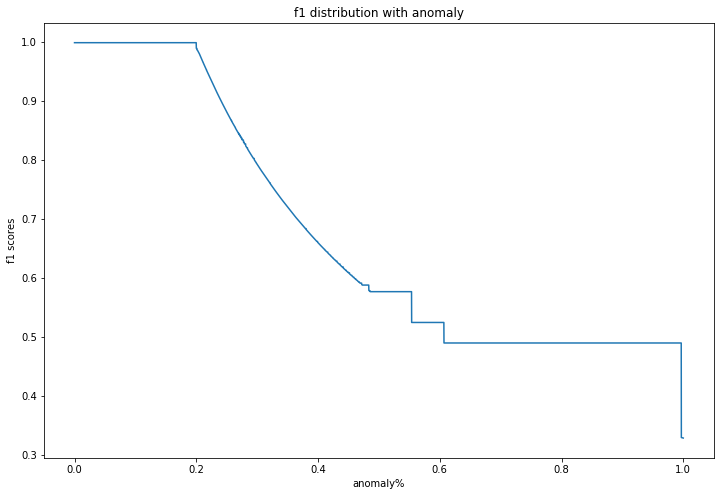

0.1999
[0.98901368]


In [71]:
anomaly_percentage_ = np.array(anomaly_percentage_vals)/10000
f1_vals = np.array(f1_vals)
print(f1_vals.max())

plt.plot(anomaly_percentage_, f1_vals,
         label=["normal", "anomaly"])

plt.title("f1 distribution with anomaly")
plt.xlabel("anomaly%")
plt.ylabel("f1 scores")

filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-f1-dist.png"
plt.savefig(filename)
plt.show()
idx = np.where(f1_vals == f1_vals.max())
print(anomaly_percentage_[idx].max())

print(f1_vals[np.where(anomaly_percentage_ == 0.20)])

1.0


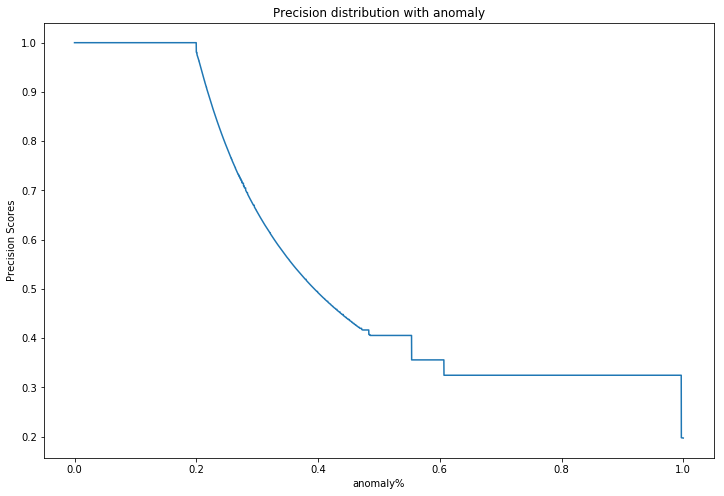

0.1999
[0.98135552]


In [72]:
anomaly_percentage_ = np.array(anomaly_percentage_vals)/10000
precision_vals = np.array(precision_vals)
print(precision_vals.max())

plt.plot(anomaly_percentage_, precision_vals,
         label=["normal", "anomaly"])

plt.title("Precision distribution with anomaly")
plt.xlabel("anomaly%")
plt.ylabel("Precision Scores")


filename = '../../models/kddcup/{}/'.format(timestamp)+timestamp + "-precision-dist.png"
plt.savefig(filename)
plt.show()
idx = np.where(precision_vals == precision_vals.max())
print(anomaly_percentage_[idx].max())

print(precision_vals[np.where(anomaly_percentage_ == 0.20)])